In [1]:
RANDOM_SEED = 42
TRAIN_METADATA = './data/train_ship_segmentations_v2.csv'
IMAGE_SIZE = 768
TARGET_SIZE = 256
BATCH_SIZE = 16
OUTPUT = './model/'
MODEL_PATH = OUTPUT + 'trained_model.h5'
TRAIN_SIZE = 30000
USE_EXISTING = True

In [2]:
import tensorflow as tf
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.__version__)
if tf.test.gpu_device_name():
	print('GPU found')
else:
	print("No GPU found")


C:\Users\Sauron\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


2.10.0
GPU found


In [3]:
import numpy as np
import pandas as pd
import random
import helpers


In [4]:

# Load the CSV file into a DataFrame
all_metadata_pd = pd.read_csv(TRAIN_METADATA).dropna(subset=['EncodedPixels']).sample(TRAIN_SIZE, random_state=RANDOM_SEED).reset_index(drop=True)
all_metadata = np.array(all_metadata_pd)
# Print the DataFrame
print(all_metadata_pd.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        30000 non-null  object
 1   EncodedPixels  30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB
None


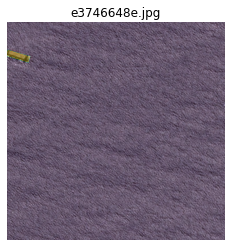

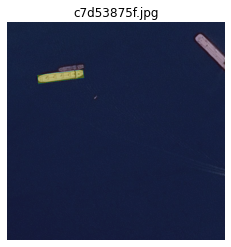

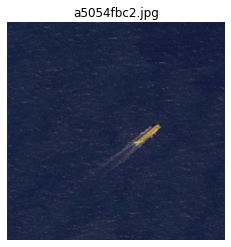

In [5]:
def render_image(row):
	image = helpers.get_image(row[0])
	mask = helpers.get_mask(row[1], (IMAGE_SIZE, IMAGE_SIZE))
	# Display the image
	helpers.render_pair(row[0], image, mask)

random.seed(RANDOM_SEED + 3)
random_images = random.sample(list(all_metadata), 3)
for i in range(0, len(random_images)):
	render_image(random_images[i])
#render_image(all_metadata[len(all_metadata) // 7])
#render_image(all_metadata[len(all_metadata) // 3])
#render_image(all_metadata[len(all_metadata) // 2])

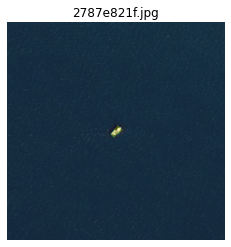

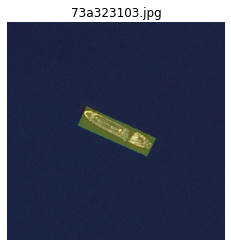

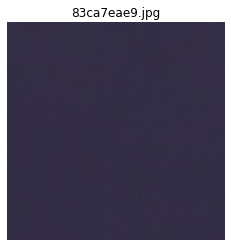

In [6]:

import random

def render_resized_image(row):
	image, mask = helpers.crop_image(row, (TARGET_SIZE, TARGET_SIZE))
	helpers.render_pair(row[0], image, mask)

random.seed(RANDOM_SEED + 8)
random_images = random.sample(list(all_metadata), 3)
for i in range(0, len(random_images)):
	render_resized_image(random_images[i])


In [7]:

from sklearn.model_selection import train_test_split

def data_generator(metadata, batch_size):
	num_samples = len(metadata)
	rand = np.random.RandomState(seed=RANDOM_SEED)
	while True:
		indices = rand.randint(0, num_samples, batch_size)
		batch_images = []
		batch_labels = []
		for idx in indices:
			image, mask = helpers.crop_image(metadata[idx], (TARGET_SIZE, TARGET_SIZE))
			batch_images.append(image * 1.0 / 255)
			batch_labels.append(mask)
		yield np.array(batch_images), np.array(batch_labels)

In [8]:
def percentage_of_ships(data, size): 
	percentages = list(map(lambda row: 1.0 * np.sum(row[1]) / (size * size), data))
	return np.sum(percentages) / len(percentages)

In [9]:

# Split the data into training and validation sets
train_data, val_data = train_test_split(
	all_metadata, test_size=0.2, random_state=RANDOM_SEED
)
train_generator = data_generator(train_data, batch_size=BATCH_SIZE)
val_generator = data_generator(val_data, batch_size=BATCH_SIZE)

batch_data = next(data_generator(train_data, batch_size=BATCH_SIZE))
print(percentage_of_ships(batch_data, TARGET_SIZE))


0.6148083855124081


In [10]:
from tensorflow import keras
from tensorflow.keras.layers import (
	Conv2D,
	Conv2DTranspose,
	MaxPooling2D,
	Dropout,
	concatenate,
	Input,
)


def conv_block(inputs, filters, kernel_size=3, activation="relu", padding="same", dropout_rate=0.0):
	conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
	conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
	if dropout_rate > 0.0:
		conv = Dropout(dropout_rate)(conv)
	return conv


def unet(input_shape, target_shape, num_classes, filters=[64, 128, 256, 512, 1024], dropout_rate=0.0):
	inputs = Input(input_shape)
	inputs = Input(input_shape)

	resized_inputs = tf.image.resize(inputs, target_shape)

	# Contracting Path (Encoder)
	convs = []
	pool = resized_inputs
	for filter_size in filters[:-1]:
		conv = conv_block(pool, filter_size, dropout_rate=dropout_rate)
		convs.append(conv)
		pool = MaxPooling2D(pool_size=(2, 2))(conv)

	# Bottleneck
	bottleneck = conv_block(pool, filters[-1], dropout_rate=dropout_rate)

	# Expanding Path (Decoder)
	up = bottleneck
	for i in range(len(filters) - 2, -1, -1):
		up = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding="same")(up)
		concat = concatenate([up, convs[i]], axis=3)
		up = conv_block(concat, filters[i], dropout_rate=dropout_rate)

	# Output
	outputs = Conv2D(1, 1, activation="sigmoid", padding="same")(up)
	resized_output = tf.image.resize(outputs, input_shape[:2])	
	model = keras.models.Model(inputs=inputs, outputs=resized_output)

	return model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# Define the Dice coefficient metric function
def dice_coefficient2(y_true, y_pred, smooth=1e-7):
	y_true_flat = K.flatten(y_true)
	y_pred_flat_float = K.flatten(y_pred)
	y_pred_flat = tf.where(y_pred_flat_float >= 0.5, 1, 0)
	y_true_sum = K.cast(K.sum(y_true_flat), 'float32')
	y_pred_sum = K.cast(K.sum(y_pred_flat), 'float32')
	intersection = K.cast(K.sum(y_true_flat * y_pred_flat), 'float32')
	dice = (2.0 * intersection + smooth) / (y_true_sum + y_pred_sum + smooth)
	return dice

def dice_coefficient(y_true, y_pred, smooth=1e-7):
	y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32
	intersection = tf.reduce_sum(y_true * y_pred)
	union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
	dice = (2.0 * intersection + smooth) / (union + smooth)
	return dice

def bce_dice_loss(y_target, y_pred):
	# dice loss metric
	y_pred_int = tf.round(y_pred)
	return binary_crossentropy(y_target, y_pred_int) + (1-dice_coefficient(y_target, y_pred)) * 10
# Compile the model with the Dice coefficient as a metric
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define model checkpoint callback to save the best model
checkpoint = ModelCheckpoint(OUTPUT + 'best_model.h5', monitor='val_loss', save_best_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
	factor=0.1,
	patience=1, 
	verbose=1, 
	mode='min',
	min_delta=0.0001, 
	cooldown=0, 
	min_lr=1e-8) 
	#reduces learning rate when a metric has stopped improving
callbacks = [early_stopping, checkpoint, reduceLROnPlat]

if USE_EXISTING == False:
	input_shape = (TARGET_SIZE, TARGET_SIZE, 3)
	target_shape = (128, 128)
	num_classes = 2
	filters = [64, 128, 256]
	optimizer = Adam(1e-3, decay=1e-6, beta_1=0.99, beta_2=0.999)
	model = unet(input_shape, target_shape, num_classes, filters=filters, dropout_rate=0.0)
else:
	optimizer = Adam(1e-5, decay=1e-6, beta_1=0.99, beta_2=0.999)
	model = keras.models.load_model(MODEL_PATH, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient})

model.compile(
	optimizer=optimizer, 
	loss=bce_dice_loss, 
	metrics=[dice_coefficient, 'accuracy'])

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['tf.image.resize[0][0]']        
                                )                                                                 
                                                                                              

In [17]:
epochs = 30

model.fit(
	train_generator, 
	steps_per_epoch=len(train_data) // BATCH_SIZE, 
	epochs=epochs, 
	validation_data=val_generator, 
	validation_steps=len(val_data) // BATCH_SIZE,
	callbacks=callbacks,
	verbose=1)

model.save(MODEL_PATH)

Epoch 1/30
1500/1500 [==============================] - 422s 275ms/step - loss: 5.3811 - dice_coefficient: 0.4991 - accuracy: 0.9757 - val_loss: 5.3428 - val_dice_coefficient: 0.5022 - val_accuracy: 0.9762 - lr: 1.0000e-05
Epoch 2/30
1500/1500 [==============================] - ETA: 0s - loss: 5.3573 - dice_coefficient: 0.5017 - accuracy: 0.9756
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
1500/1500 [==============================] - 423s 282ms/step - loss: 5.3573 - dice_coefficient: 0.5017 - accuracy: 0.9756 - val_loss: 5.5293 - val_dice_coefficient: 0.4849 - val_accuracy: 0.9753 - lr: 1.0000e-05
Epoch 3/30
1500/1500 [==============================] - ETA: 0s - loss: 5.3166 - dice_coefficient: 0.5062 - accuracy: 0.9753
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
1500/1500 [==============================] - 431s 287ms/step - loss: 5.3166 - dice_coefficient: 0.5062 - accuracy: 0.9753 - val_loss: 5.3909 - val_dice_coefficient